# MODEL OLUŞTURMA

__HAM VERİ GÖRSELLEŞTİRME__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/preprocessed_review.csv")

In [3]:
def label_review(rate):
    if rate >= 4: return 'positive'
    elif rate == 3: return 'neutral'
    else: return 'negative'

df['sentiment'] = df['Puan'].apply(label_review)

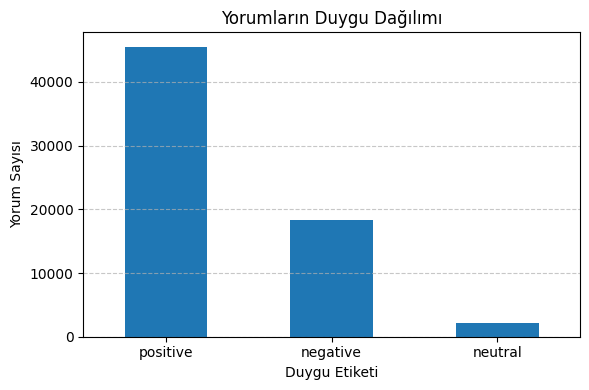

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar')

plt.title('Yorumların Duygu Dağılımı')
plt.xlabel('Duygu Etiketi')
plt.ylabel('Yorum Sayısı')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

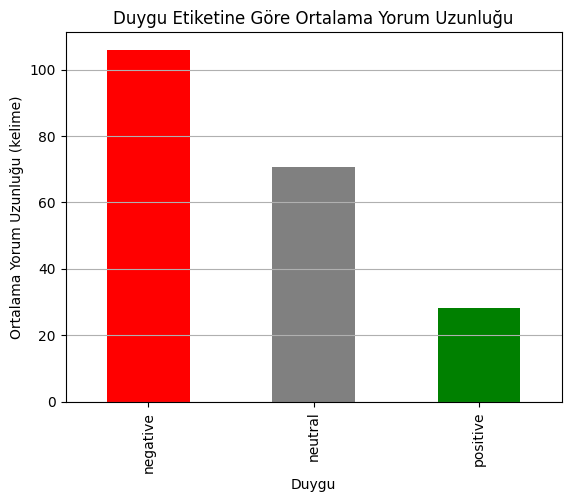

In [5]:
df["review_length"] = df["lemmas"].apply(len)

df.groupby("sentiment")["review_length"].mean().reindex(["negative", "neutral", "positive"]).plot(
    kind="bar", color=["red", "gray", "green"]
)
plt.title("Duygu Etiketine Göre Ortalama Yorum Uzunluğu")
plt.xlabel("Duygu")
plt.ylabel("Ortalama Yorum Uzunluğu (kelime)")
plt.grid(axis='y')
plt.show()

# SENTIMENT ANALYSIS

__transformation tabanlı model analizi__

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "tabularisai/multilingual-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [7]:
import ast

texts = df["lemmas"].dropna().apply(lambda x: " ".join(ast.literal_eval(x))).tolist()
results = sentiment_pipe(texts, batch_size=128)

In [8]:
df["pred_label"] = [res["label"] for res in results]
df["pred_score"] = [res["score"] for res in results]

In [9]:
def normalize_label(label):
    label = label.lower()
    if "neg" in label:
        return "negative"
    elif "notr" in label or "neutral" in label:
        return "neutral"
    elif "pos" in label:
        return "positive"
    return "unknown"

df["normalized_pred_label"] = df["pred_label"].apply(normalize_label)

In [10]:
import ast

positive_keywords = ["süper", "harika", "mükemmel", "çok güzel", "teşekkür", "bayıldım", "efsane", "beğen", "unlosttan", "unlost" ]

def force_positive(row):
    text = " ".join(ast.literal_eval(row["lemmas"])) if isinstance(row["lemmas"], str) else " ".join(row["lemmas"])
    if any(kw in text for kw in positive_keywords) or "unlost" in text:
        return "positive"
    return row["normalized_pred_label"]

df["normalized_pred_label"] = df.apply(force_positive, axis=1)

__Kullandığımız modele göre negative ve pozitiflerde oldukça iyi sonuçlar elde ettik ancak neutral verinin azlığından dolayı bu alanda neredeyse hiç doğru tahminimiz yok__

In [11]:
from sklearn.metrics import classification_report
print(classification_report(df["sentiment"], df["normalized_pred_label"]))

              precision    recall  f1-score   support

    negative       0.67      0.62      0.65     18259
     neutral       0.07      0.24      0.10      2208
    positive       0.90      0.81      0.86     45497

    accuracy                           0.74     65964
   macro avg       0.55      0.56      0.54     65964
weighted avg       0.81      0.74      0.77     65964



In [12]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['sakin', 'gir']",1,2025-07-19 22:54:03,negative,16,Positive,0.357571,positive
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",4,2025-07-19 15:19:42,positive,60,Very Negative,0.275996,negative
2,"['ses', 'kod']",1,2025-07-19 09:00:43,negative,14,Neutral,0.321734,neutral
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",5,2025-07-19 06:27:28,positive,51,Negative,0.350649,negative
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",1,2025-07-18 14:50:20,negative,176,Negative,0.402275,negative
...,...,...,...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",5,2017-10-25 19:51:01,positive,51,Neutral,0.709147,neutral
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",1,2017-10-25 15:07:58,negative,84,Very Positive,0.352934,positive
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",3,2017-10-21 10:55:40,neutral,68,Neutral,0.301251,neutral
65962,"['arayüz', 'gerçekten', 'iyi']",5,2017-10-18 19:05:47,positive,30,Positive,0.524642,positive


In [13]:
df[["sentiment","normalized_pred_label"]]

,sentiment,normalized_pred_label
0,negative,positive
1,positive,negative
2,negative,neutral
3,positive,negative
4,negative,negative
...,...,...
65959,positive,neutral
65960,negative,positive
65961,neutral,neutral
65962,positive,positive


__data klasöründen tüm veriye erişilebilir__

In [14]:
df[["lemmas", "sentiment", "review_length", "normalized_pred_label", "Tarih"]].to_csv("../data/sentiment_results.csv", index=False)

__burada görünümün daha anlaşılır olabilmesi için sentiment ve pred_sentimentin renklendirilip daha iyi görünüm sağlandı__

In [15]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

df[["lemmas", "sentiment", "normalized_pred_label", "Tarih"]].to_excel("../data/sentiment_results.xlsx", index=False)

wb = load_workbook("../data/sentiment_results.xlsx")
ws = wb.active

colors = {
    "neutral": "D9D9D9", 
    "positive": "C6EFCE", 
    "negative": "F2DCDB", 
}

for row in range(2, ws.max_row + 1):
    sentiment = ws[f"B{row}"].value 
    pred = ws[f"C{row}"].value      
    if sentiment in colors:
        fill_true = PatternFill(start_color=colors[sentiment], end_color=colors[sentiment], fill_type="solid")
        ws[f"B{row}"].fill = fill_true
    if pred in colors:
        fill_pred = PatternFill(start_color=colors[pred], end_color=colors[pred], fill_type="solid")
        ws[f"C{row}"].fill = fill_pred

wb.save("../data/sentiment_results_colored.xlsx")

__NEGATIF YORUMLARDA ONERI KISMI__

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_labeled = pd.read_csv("yapici_egitim_seti.csv")
X_text = df_labeled['lemmas_text']
y = df_labeled['yapici_mi']

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.33      0.20      0.25         5

    accuracy                           0.85        40
   macro avg       0.61      0.57      0.58        40
weighted avg       0.82      0.85      0.83        40



In [17]:
print(df_labeled['yapici_mi'].value_counts())

yapici_mi
0    173
1     27
Name: count, dtype: int64


In [18]:
 #devam edecek burada öneri var mı yok mu tespit edemediğim için istenilen noktaya gelemedi bu yüzden istediğim sonuca ulasamadığım için es geçiyorum.

In [19]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['sakin', 'gir']",1,2025-07-19 22:54:03,negative,16,Positive,0.357571,positive
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",4,2025-07-19 15:19:42,positive,60,Very Negative,0.275996,negative
2,"['ses', 'kod']",1,2025-07-19 09:00:43,negative,14,Neutral,0.321734,neutral
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",5,2025-07-19 06:27:28,positive,51,Negative,0.350649,negative
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",1,2025-07-18 14:50:20,negative,176,Negative,0.402275,negative
...,...,...,...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",5,2017-10-25 19:51:01,positive,51,Neutral,0.709147,neutral
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",1,2017-10-25 15:07:58,negative,84,Very Positive,0.352934,positive
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",3,2017-10-21 10:55:40,neutral,68,Neutral,0.301251,neutral
65962,"['arayüz', 'gerçekten', 'iyi']",5,2017-10-18 19:05:47,positive,30,Positive,0.524642,positive


In [20]:
df_cleaned = pd.read_csv("../data/sentiment_results.csv")

In [21]:
df_cleaned

,lemmas,sentiment,review_length,normalized_pred_label,Tarih
0,"['sakin', 'gir']",negative,16,positive,2025-07-19 22:54:03
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",positive,60,negative,2025-07-19 15:19:42
2,"['ses', 'kod']",negative,14,neutral,2025-07-19 09:00:43
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",positive,51,negative,2025-07-19 06:27:28
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",negative,176,negative,2025-07-18 14:50:20
...,...,...,...,...,...
65959,"['iyi', 'ancak', 'günlük', 'giriş', 'kredi', '...",positive,51,neutral,2017-10-25 19:51:01
65960,"['arkadaş', 'türk', 'sel', 'bayi', 'mail', 'ad...",negative,84,positive,2017-10-25 15:07:58
65961,"['arena', 'valon', 'oyun', 'nakit', 'çek', 'oy...",neutral,68,neutral,2017-10-21 10:55:40
65962,"['arayüz', 'gerçekten', 'iyi']",positive,30,positive,2017-10-18 19:05:47


In [22]:
import ast

df_cleaned["lemmas"] = df_cleaned["lemmas"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [23]:
negatif_df = df_cleaned[df_cleaned["normalized_pred_label"] == "negative"].copy()
df_cleaned = negatif_df.dropna(subset=["lemmas"])

In [24]:
suggest_df = df_cleaned[
    df_cleaned["lemmas"].apply(lambda x: any(
        word in x for word in [
    "bence", "keşke", "ol", "geliştir", "ek", "daha", "iyi", "eksik", "şöyle",
    "böyle", "öner", "düzenle", "gerek", "ist", "lazım", "koy", "çıkar", "yenile",
    "artır", "azalt", "sağla", "sun", "yap", "olabilir", "olsun"        ]
    ))
]

In [26]:
from keybert import KeyBERT

kw_model = KeyBERT(model="paraphrase-multilingual-MiniLM-L12-v2")

def extract_keywords(tokens):
    if not isinstance(tokens, list) or len(tokens) == 0:
        return []
    text = " ".join(tokens)
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=5
    )
    return [kw[0] for kw in keywords]

suggest_df.loc[:, "onerilen_konular"] = suggest_df["lemmas"].apply(extract_keywords)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\ismet bal\anaconda3\envs\paycell_review_analysis\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ismet bal\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\ismet bal\AppData\Local\Temp\ipykernel_38064\2840568943.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suggest_df.loc[:, "onerilen_konular"] = suggest_df["lemmas"].apply(extract_keywords)


In [27]:
output_df = suggest_df[["lemmas", "onerilen_konular"]].copy()
output_df.to_csv("tokens_with_oneriler.csv", index=False, encoding="utf-8-sig")

In [28]:
import pandas as pd
import ast

df = pd.read_csv("tokens_with_oneriler.csv")
df["onerilen_konular"] = df["onerilen_konular"].apply(ast.literal_eval)
df["metin"] = df["onerilen_konular"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
df = df[df["metin"].str.strip().astype(bool)].copy()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["metin"])

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [31]:
for i in range(6):
    print(f"\nKÜME {i}")
    print(df[df["cluster"] == i]["onerilen_konular"].head(10).to_string(index=False))


KÜME 0
[şifre unut, kadar şifre, müşteri hizmet, gerçe...
[şifre yenile, şifre, kod rağmen, değil müşteri...
[şifre unut, unut şifre, şifre yenile, şifre, u...
[şifre koy, uğraş şifre, koy şifre, şifre, türl...
[tekrar defalarca, arkadaş şifre, şifre yenile,...
[şifre yenile, çalış şifre, iste şifre, şifre, ...
[şifre yenile, giriş şifre, şifre, güvenlik sor...
[şifre unut, şifre iste, şifre, boyunca şifre, ...
[şifre yenile, şifre, sürekli hata, hata, sürekli]
[şifre kabul, şifre yen, hafta şifre, şifre, sa...

KÜME 1
[kart işlem, aktar kart, kart bilgi, fatura yan...
[yıldız kart, kimlik tanı, aktarım kimlik, kart...
[kullandirtmayin kart, aktif kart, fakat kart, ...
[kart iyi, kart başka, tavsiye kart, başka kart...
[banka kart, kart yüklem, kart kalite, kaybet m...
[hata kart, yükle kart, kimlik doğrula, gerekiy...
[kredi kart, kart yükle, bugün kart, üstelik kr...
[kart para, sanal kart, müşteri hizmet, ara müş...
[kullan kart, inaktif kart, cevapla kart, kart ...
[kart kır, kötü

In [32]:
from collections import Counter
import ast

for i in range(6):
    print(f"\nKÜME {i}")
    kelimeler = []
    
    for val in df[df["cluster"] == i]["onerilen_konular"]:
        if isinstance(val, str):
            try:
                val = ast.literal_eval(val)
            except:
                continue
        if isinstance(val, list):
            kelimeler.extend(val)
    
    en_sik = Counter(kelimeler).most_common(6)
    print("En sık geçenler:", [x[0] for x in en_sik])


KÜME 0
En sık geçenler: ['şifre', 'şifre yenile', 'şifre unut', 'unut şifre', 'şifre gir', 'yeni şifre']

KÜME 1
En sık geçenler: ['sanal kart', 'kart kullan', 'banka kart', 'kredi kart', 'kart para', 'kart yüklem']

KÜME 2
En sık geçenler: ['gerek', 'yok', 'gerek yok', 'telefon', 'müşteri hizmet', 'keşke']

KÜME 3
En sık geçenler: ['turkcell', 'turkcell böyle', 'kullan turkcell', 'yok turkcell', 'müşteri', 'turkcell müşteri']

KÜME 4
En sık geçenler: ['fatura öde', 'banka', 'para gönder', 'banka hesap', 'fatura yansı', 'öde']

KÜME 5
En sık geçenler: ['iyi', 'iyi değil', 'değil', 'pek', 'iyi kötü', 'kötü']


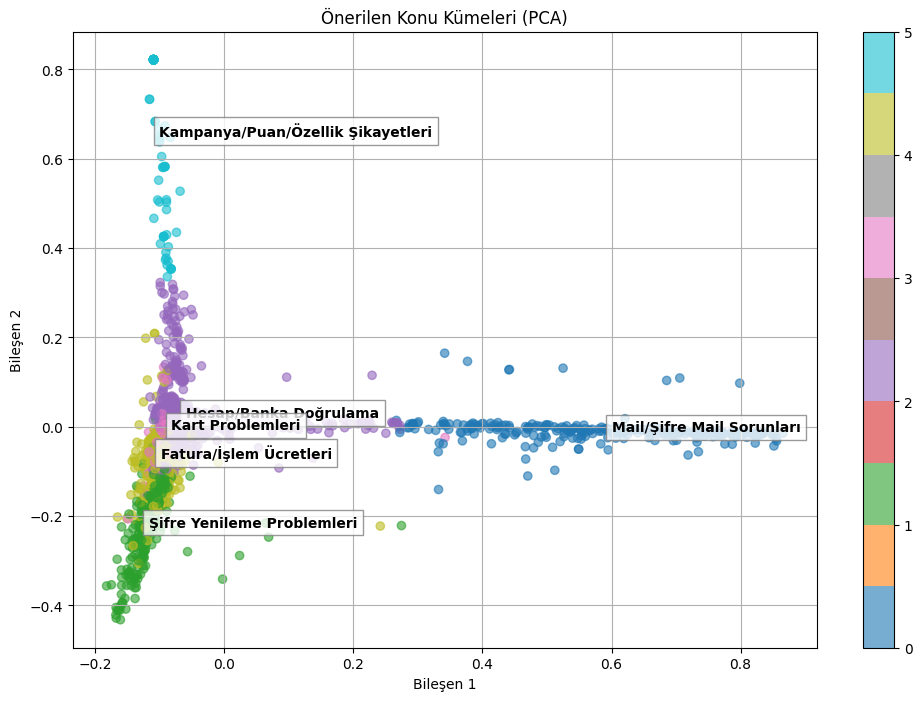

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cluster_labels = {
    0: "Mail/Şifre Mail Sorunları",
    1: "Şifre Yenileme Problemleri",
    2: "Hesap/Banka Doğrulama",
    3: "Kart Problemleri",
    4: "Fatura/İşlem Ücretleri",
    5: "Kampanya/Puan/Özellik Şikayetleri"
}

df["cluster_label"] = df["cluster"].map(cluster_labels)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", alpha=0.6)


for cluster_id in sorted(df["cluster"].unique()):
    indices = df["cluster"] == cluster_id
    x_mean = X_2d[indices, 0].mean()
    y_mean = X_2d[indices, 1].mean()
    plt.text(x_mean, y_mean, cluster_labels[cluster_id], fontsize=10, weight='bold', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.title("Önerilen Konu Kümeleri (PCA)")
plt.xlabel("Bileşen 1")
plt.ylabel("Bileşen 2")
plt.colorbar(scatter, ticks=range(len(cluster_labels)))
plt.grid(True)
plt.show()

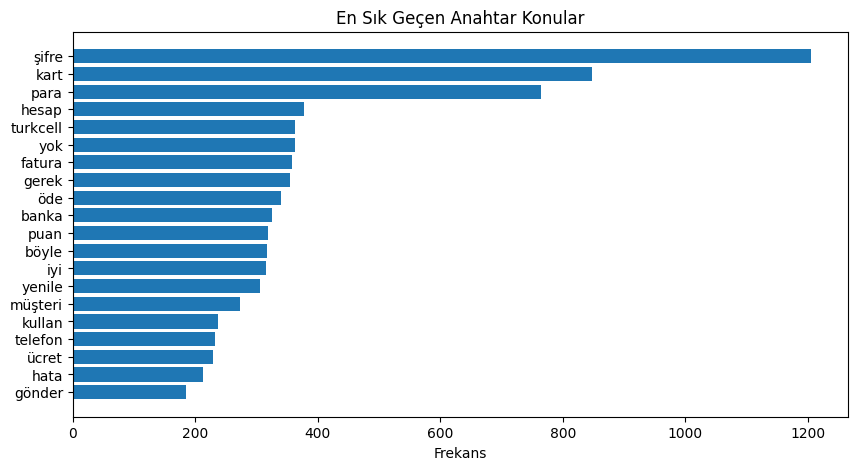

In [34]:
from collections import Counter
import matplotlib.pyplot as plt

all_keywords = df["metin"].str.split().sum()  # tüm kelimeleri listele
common = Counter(all_keywords).most_common(20)

labels, counts = zip(*common)
plt.figure(figsize=(10, 5))
plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.title("En Sık Geçen Anahtar Konular")
plt.xlabel("Frekans")
plt.show()

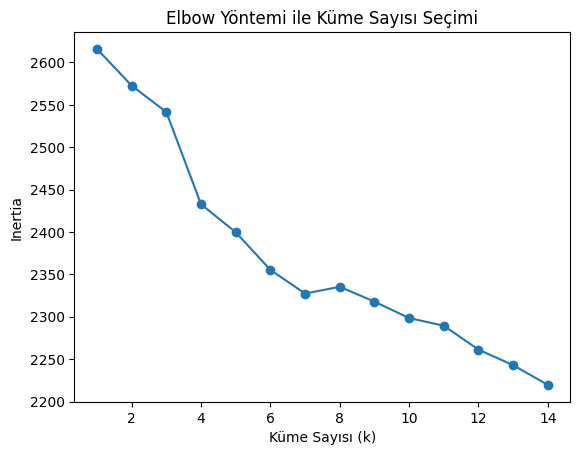

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Yöntemi ile Küme Sayısı Seçimi")
plt.show()

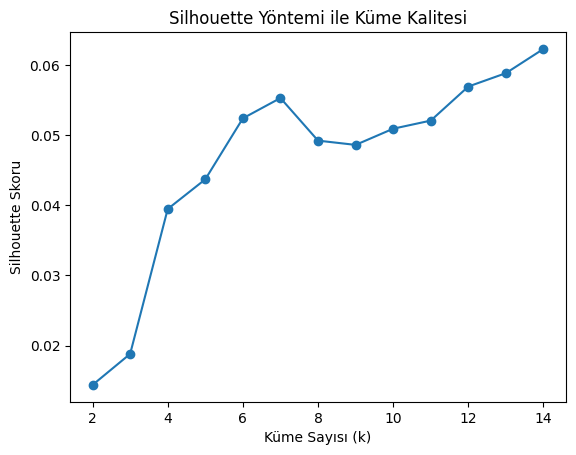

In [36]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")
plt.title("Silhouette Yöntemi ile Küme Kalitesi")
plt.show()

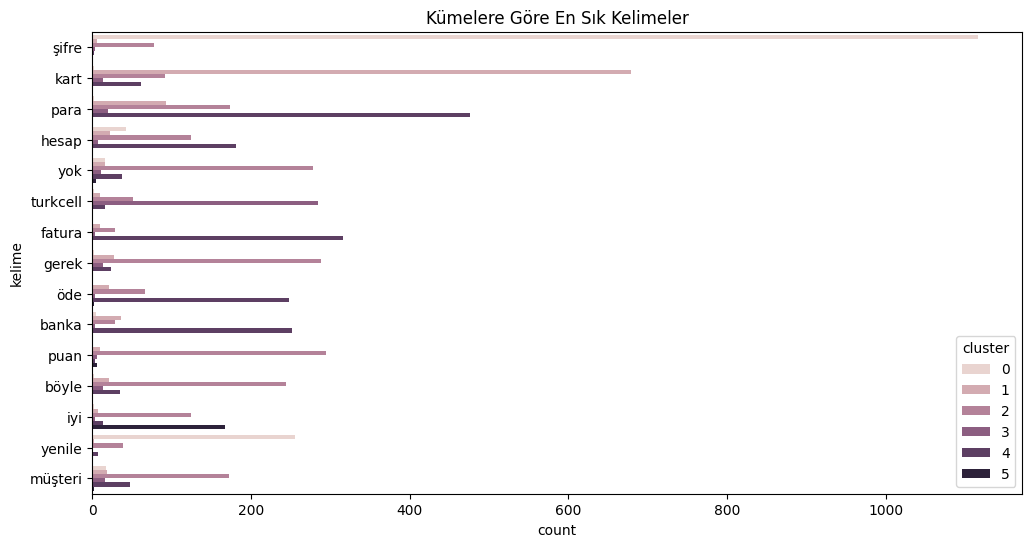

In [37]:
import seaborn as sns
import pandas as pd

rows = []
for i, row in df.iterrows():
    for kelime in row["metin"].split():
        rows.append({"cluster": row["cluster"], "kelime": kelime})

kelime_df = pd.DataFrame(rows)
plt.figure(figsize=(12, 6))
sns.countplot(data=kelime_df, y="kelime", order=kelime_df["kelime"].value_counts().head(15).index, hue="cluster")
plt.title("Kümelere Göre En Sık Kelimeler")
plt.show()

__POZITIF VERILER ICIN__

In [38]:
negatif_df = df_cleaned[df_cleaned["normalized_pred_label"] == "negative"].copy()
df_cleaned = negatif_df.dropna(subset=["lemmas"])

In [39]:
import ast
df_cleaned = pd.read_csv("../data/sentiment_results.csv")
df_cleaned["lemmas"] = df_cleaned["lemmas"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

positive_df = df_cleaned[df_cleaned["normalized_pred_label"] == "positive"].copy()
df_cleaned = positive_df.dropna(subset=["lemmas"])

In [40]:
suggest_df = df_cleaned[df_cleaned["normalized_pred_label"] == "positive"].copy()

In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT(model="paraphrase-multilingual-MiniLM-L12-v2")

def extract_keywords(tokens):
    if not isinstance(tokens, list) or len(tokens) == 0:
        return []
    text = " ".join(tokens)
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=5
    )
    return [kw[0] for kw in keywords]

suggest_df.loc[:, "positif_oneriler"] = suggest_df["lemmas"].apply(extract_keywords)

In [ ]:
output_df = suggest_df[["lemmas", "positif_oneriler"]].copy()
output_df.to_csv("lemmas_suggest_positive.csv", index=False, encoding="utf-8-sig")

In [ ]:
import pandas as pd
import ast

df = pd.read_csv("lemmas_suggest_positive.csv")

df["positif_oneriler"] = df["positif_oneriler"].apply(ast.literal_eval)

df["metin"] = df["positif_oneriler"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else ""
)

df = df[df["metin"].str.strip().astype(bool)].copy()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["metin"])

kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [ ]:
for i in range(6):
    print(f"\nKÜME {i}")
    print(df[df["cluster"] == i]["positif_oneriler"].head(5).to_string(index=False))

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10")
plt.title("KMeans ile Önerilen Konu Kümeleme (PCA)")
plt.xlabel("Bileşen 1")
plt.ylabel("Bileşen 2")
plt.colorbar(scatter, ticks=range(6))
plt.grid(True)
plt.show()

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

all_keywords = df["metin"].str.split().sum() 
common = Counter(all_keywords).most_common(20)

labels, counts = zip(*common)
plt.figure(figsize=(10, 5))
plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.title("En Sık Geçen Anahtar Konular")
plt.xlabel("Frekans")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # TF-IDF matrisi
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Yöntemi ile Küme Sayısı Seçimi")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")
plt.title("Silhouette Yöntemi ile Küme Kalitesi")
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

rows = []
for i, row in df.iterrows():
    for kelime in row["metin"].split():
        rows.append({"cluster": row["cluster"], "kelime": kelime})

kelime_df = pd.DataFrame(rows)
plt.figure(figsize=(12, 6))
sns.countplot(data=kelime_df, y="kelime", order=kelime_df["kelime"].value_counts().head(15).index, hue="cluster")
plt.title("Kümelere Göre En Sık Kelimeler")
plt.show()